# **CECS 456 Final Project: Churn Prediction**
**Andrew Hua and Luke Nguyen** <br><br>
## 1. Data Preprocessing

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

In [4]:
# 1. EDA: Basic info and summary
churn_data = pd.read_csv('Churn_Modelling.csv')

print("Dataset Info:")
print(churn_data.info())
print("\nDataset Description:")
print(churn_data.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None

Dataset Description:
         RowNumber    CustomerId   CreditScore       

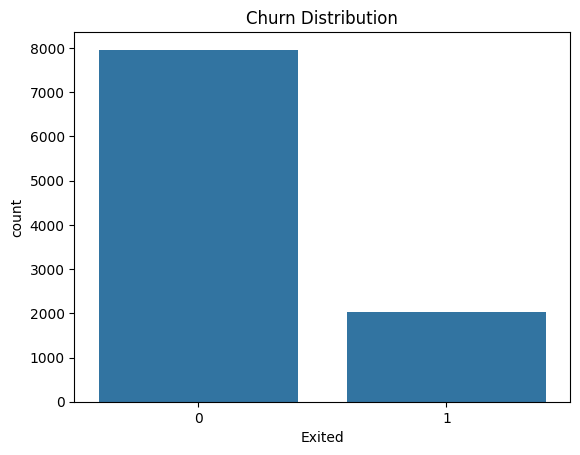


Missing Values:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [5]:
# Visualize target variable distribution
sns.countplot(data=churn_data, x='Exited')
plt.title('Churn Distribution')
plt.show()
# Check for missing values
print("\nMissing Values:")
print(churn_data.isnull().sum())

In [6]:
# Handle Outliers by using IQR
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
for col in numerical_features:
    Q1 = churn_data[col].quantile(0.25)
    Q3 = churn_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = churn_data[(churn_data[col] < lower_bound) | (churn_data[col] > upper_bound)]
    print(f"Outliers in {col}: {len(outliers)}")



Outliers in CreditScore: 15
Outliers in Age: 359
Outliers in Tenure: 0
Outliers in Balance: 0
Outliers in EstimatedSalary: 0



Class Weights:
{0: np.float64(0.6279434850863422), 1: np.float64(2.4539877300613497)}

Final Dataset Shapes:
X_train: (8000, 10), y_train: (8000,)
X_test: (2000, 10), y_test: (2000,)


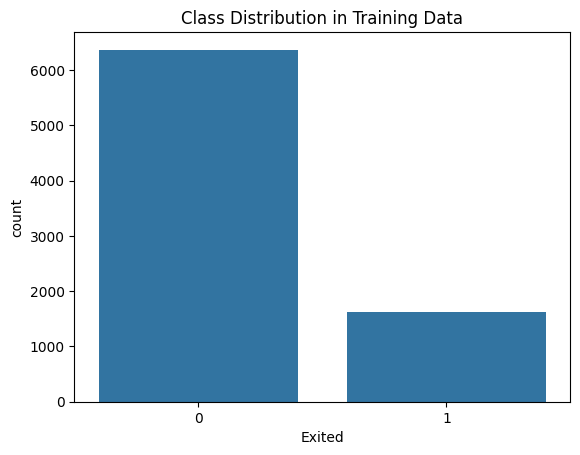

In [7]:
#Encode Categorical Variables
categorical_features = ['Geography', 'Gender']
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    churn_data[col] = le.fit_transform(churn_data[col])
    label_encoders[col] = le
    
#Split Dataset into Train and Test Sets
X = churn_data.drop(columns=['Exited', 'RowNumber', 'CustomerId', 'Surname'])
y = churn_data['Exited']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#Normalize Numerical Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
churn_data[numerical_features] = scaler.fit_transform(churn_data[numerical_features])

#Compute Class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("\nClass Weights:")
print(class_weight_dict)

# Final Dataset Shapes
print("\nFinal Dataset Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Visualize Class Distribution
sns.countplot(x=y_train)
plt.title('Class Distribution in Training Data')
plt.show()


In [8]:
# Function to Train and Evaluate Models
def train_and_evaluate(model, model_name, X_train_custom=None, X_test_custom=None):
    print(f"\nTraining {model_name}...")

    # Use custom data if provided
    X_tr = X_train_custom if X_train_custom is not None else X_train
    X_te = X_test_custom if X_test_custom is not None else X_test

    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)

    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    return accuracy

# Model Implementations
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Support Vector Machine (SVM)": SVC(kernel='linear', random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Naïve Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "Deep Learning (MLP)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

# Train and Evaluate Each Model
results = {}
for model_name, model in models.items():
    results[model_name] = train_and_evaluate(model, model_name)

# Summary of Results
print("\nModel Performance Summary:")
for model_name, accuracy in results.items():
    print(f"{model_name}: Accuracy = {accuracy:.2f}")


Training Decision Tree...

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1593
           1       0.45      0.48      0.46       407

    accuracy                           0.78      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.78      0.78      0.78      2000

Decision Tree Accuracy: 0.78

Training Support Vector Machine (SVM)...

Support Vector Machine (SVM) Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      1593
           1       0.26      0.04      0.07       407

    accuracy                           0.78      2000
   macro avg       0.53      0.51      0.47      2000
weighted avg       0.69      0.78      0.71      2000

Support Vector Machine (SVM) Accuracy: 0.78

Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f

c:\Users\Luke\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.78      0.46      0.58       407

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.86      0.86      0.85      2000

Random Forest Accuracy: 0.86

Training XGBoost...

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1593
           1       0.68      0.47      0.56       407

    accuracy                           0.85      2000
   macro avg       0.78      0.71      0.73      2000
weighted avg       0.83      0.85      0.84      2000

XGBoost Accuracy: 0.85

Training Deep Learning (MLP)...

Deep Learning (MLP) Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1593
           1     

## 2. Model Improvements

### Hyperparameter Tuning

In [ ]:
# Using GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Function for using GridSearchCV to find the best parameters for a model then tune it
def tune_model(model, param_grid, model_name):
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Best Params for {model_name}: {grid.best_params_}")
    best_model = grid.best_estimator_

    # Retrain (and evaluate) with tuned model
    return train_and_evaluate(best_model, f"Tuned {model_name}")

# Hyperparameter grid for each model (except naive bayes, no tunable hyperparameters)
param_grids = {
    "Decision Tree": {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Support Vector Machine (SVM)": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear']
    },
    # "Naïve Bayes": {},
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 10]
    },
    "Deep Learning (MLP)": {
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01]
    }
}

# Train and Evaluate Each Model
results_tuning = {}
for model_name, param_grid in param_grids.items():
    model = models[model_name]
    results[model_name] = tune_model(model, param_grid, model_name)

# Summary of Results
print("\nModel Performance Summary:")
for model_name, accuracy in results_tuning.items():
    print(f"{model_name}: Accuracy = {accuracy:.2f}")

Best Params for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}

Training Tuned Decision Tree...

Tuned Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1593
           1       0.82      0.37      0.51       407

    accuracy                           0.86      2000
   macro avg       0.84      0.68      0.71      2000
weighted avg       0.85      0.86      0.83      2000

Tuned Decision Tree Accuracy: 0.86


### Feature Selection

In [ ]:
# Use Recursive Feature Elimination (RFE) for feature selection
from sklearn.feature_selection import RFE
from sklearn.base import clone

# Feature selection implementation function
def select_features_with_rfe(model, model_name, num_features):
    # Copy model
    base_model = clone(model)
    
    # Initialize selctor and fit on training data
    selector = RFE(estimator=base_model, n_features_to_select=num_features)
    selector.fit(X_train, y_train)

    # Transform datasets
    X_train_rfe = selector.transform(X_train)
    X_test_rfe = selector.transform(X_test)

    # Retrain the model on selected features and evaluate
    selected_model = base_model.fit(X_train_rfe, y_train)
    return train_and_evaluate(
        selected_model,
        f"{model_name} with RFE ({num_features} features)",
        X_train_custom=X_train_rfe,
        X_test_custom=X_test_rfe
    )

# Apply RFE
num_features = 10  # number of features to keep (can adjust this value)
rfe_compatible_models = ["Decision Tree", "Support Vector Machine (SVM)", "Logistic Regression", "Random Forest", "XGBoost"]

results_rfe = {}
for model_name in rfe_compatible_models:
    model = models[model_name]
    
    # Skip RBF-kernel SVM
    if model_name == "Support Vector Machine (SVM)" and model.kernel != 'linear':
        print(f"Skipping RFE for {model_name} (non-linear kernel)")
        continue
    
    # Select features and handle incompatible models
    try:
        results_rfe[model_name] = select_features_with_rfe(model, model_name, num_features)
    except Exception as e:
        print(f"RFE failed for {model_name}: {e}")

# Summary of Results
print("\nFeature Selection (RFE) Performance Summary:")
for model_name, accuracy in results_rfe.items():
    print(f"{model_name}: Accuracy = {accuracy:.2f}")


Training Decision Tree with RFE (10 features)...

Decision Tree with RFE (10 features) Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1593
           1       0.45      0.48      0.47       407

    accuracy                           0.78      2000
   macro avg       0.66      0.67      0.66      2000
weighted avg       0.78      0.78      0.78      2000

Decision Tree with RFE (10 features) Accuracy: 0.78

Training Support Vector Machine (SVM) with RFE (10 features)...

Support Vector Machine (SVM) with RFE (10 features) Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1593
           1       0.00      0.00      0.00       407

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000

Support Vector Machine (SVM) with RFE (10 

## 3. Model Comparison and Interpretation

In [9]:
# Imports
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

detailed_results = {}

'''Not sure if I should use improved models or not'''
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    detailed_results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": roc_auc,
        "FPR": fpr,
        "TPR": tpr
    }

# Print performance comparison table
print("\n=== Model Performance Comparison ===")
for model_name, metrics in detailed_results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        if isinstance(value, float):
            print(f"{metric}: {value:.2f}")


=== Model Performance Comparison ===

Decision Tree:
Accuracy: 0.78
Precision: 0.45
Recall: 0.48
F1 Score: 0.46
AUC: 0.66

Support Vector Machine (SVM):
Accuracy: 0.78
Precision: 0.26
Recall: 0.04
F1 Score: 0.07
AUC: 0.65

Logistic Regression:
Accuracy: 0.79
Precision: 0.42
Recall: 0.06
F1 Score: 0.11
AUC: 0.69

Naïve Bayes:
Accuracy: 0.79
Precision: 0.35
Recall: 0.06
F1 Score: 0.11
AUC: 0.75

Random Forest:
Accuracy: 0.86
Precision: 0.78
Recall: 0.46
F1 Score: 0.58
AUC: 0.85

XGBoost:
Accuracy: 0.85
Precision: 0.68
Recall: 0.47
F1 Score: 0.56
AUC: 0.83

Deep Learning (MLP):
Accuracy: 0.64
Precision: 0.25
Recall: 0.38
F1 Score: 0.30
AUC: 0.54


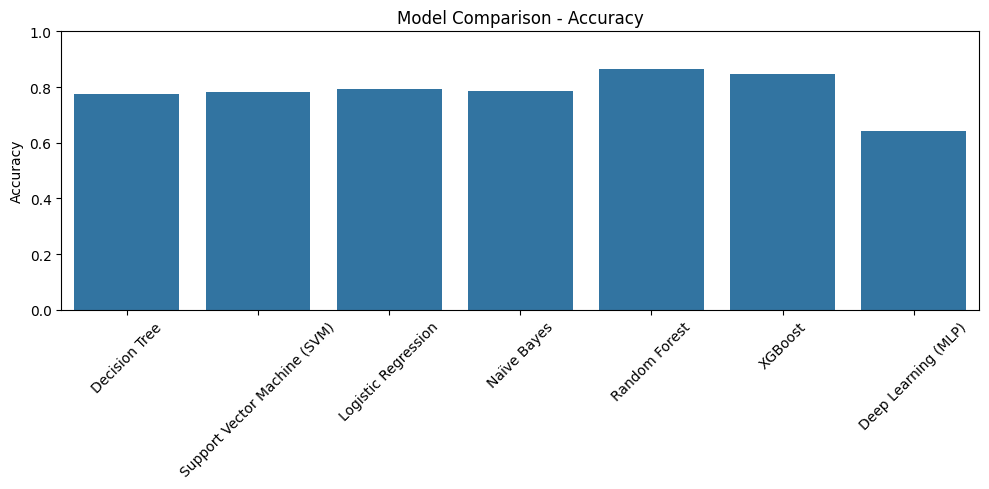

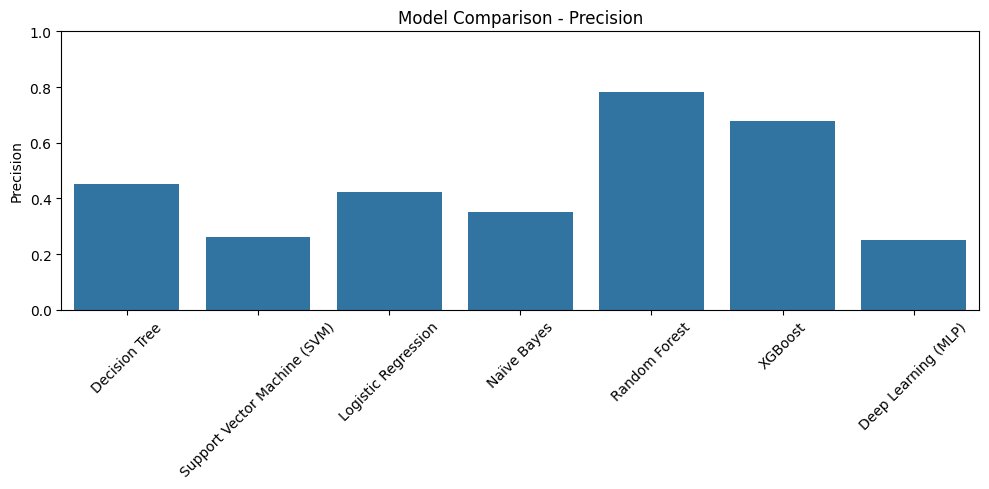

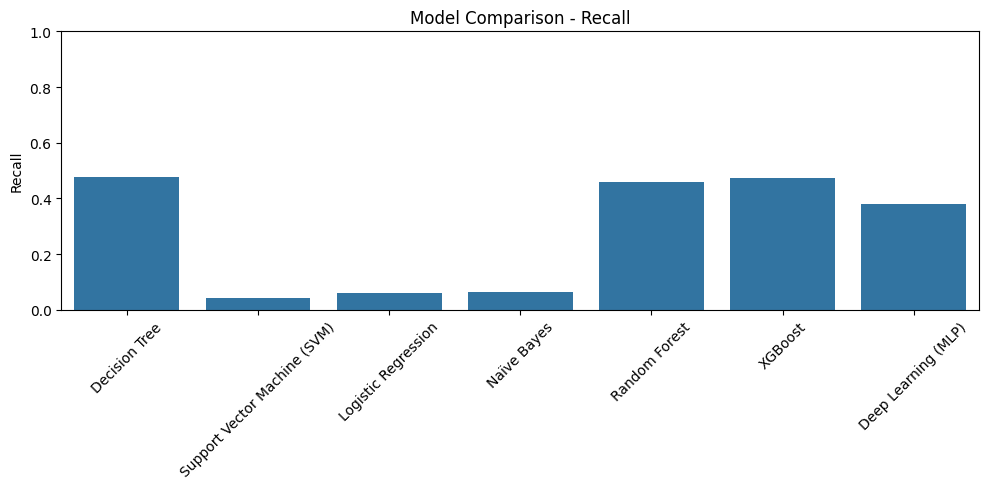

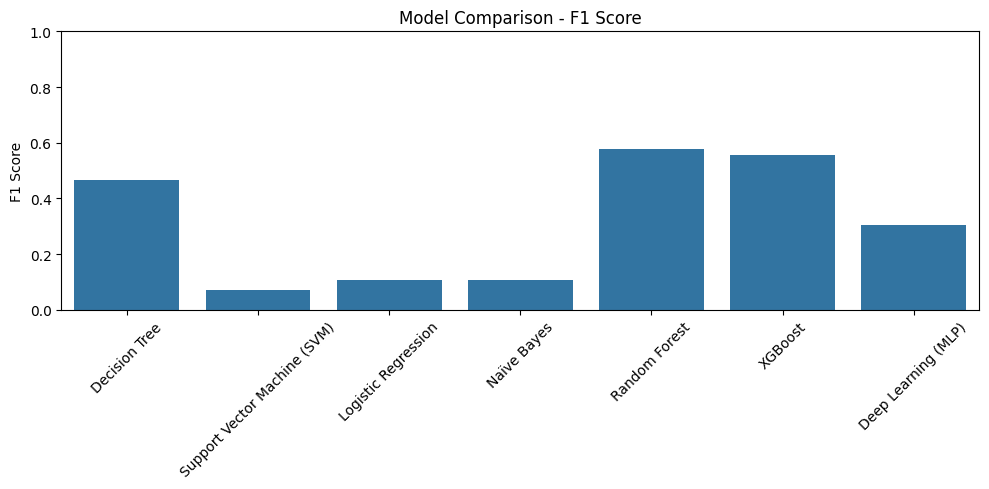

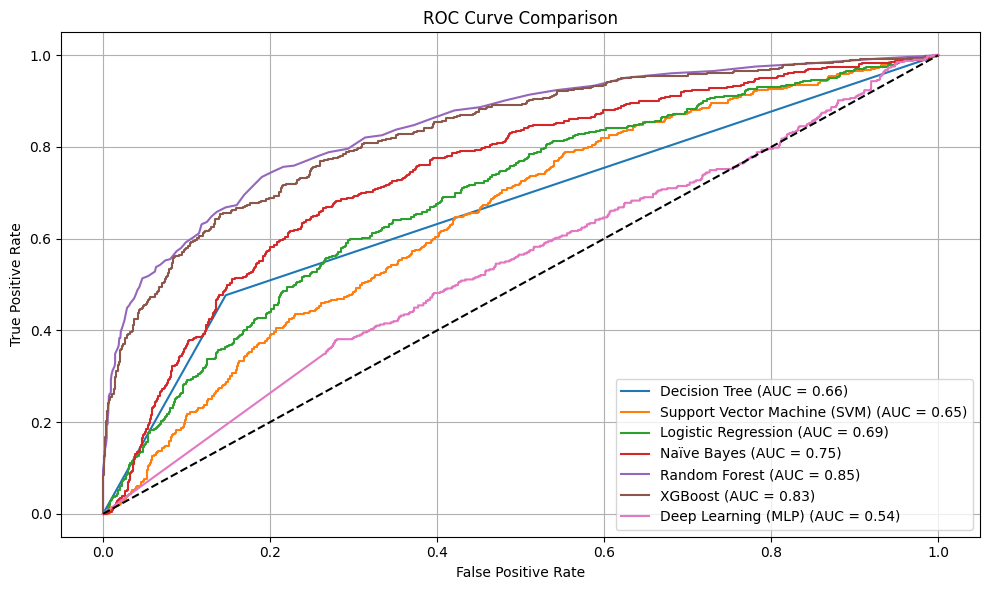

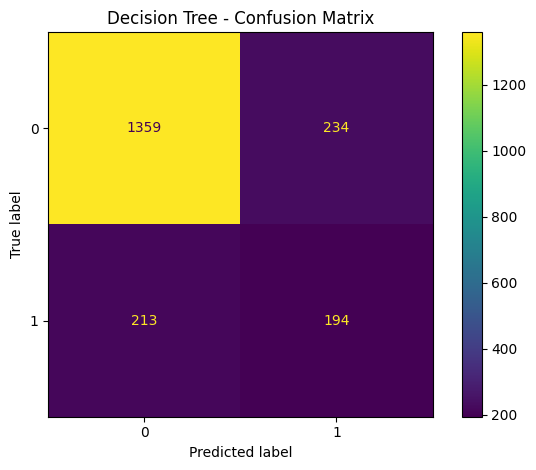

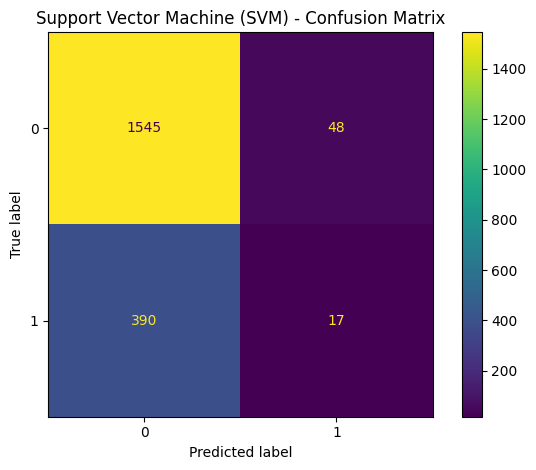

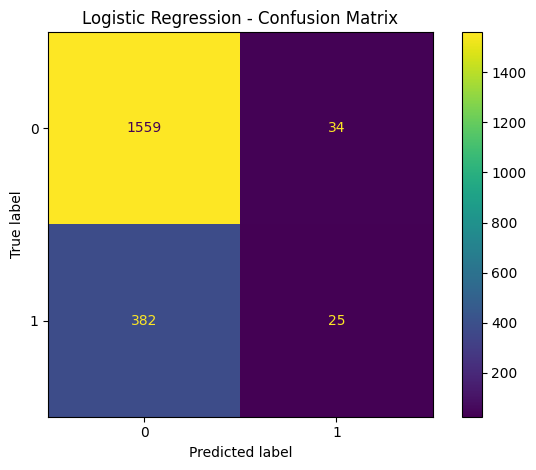

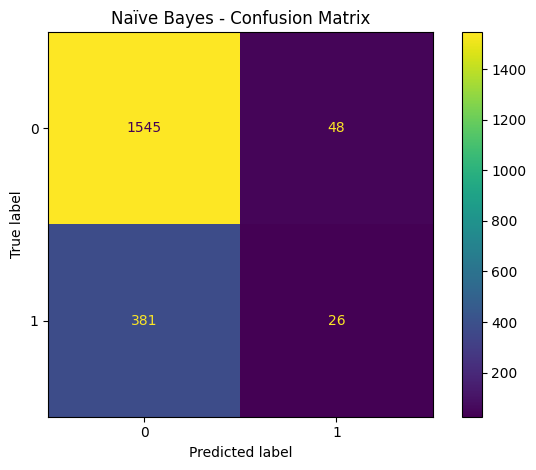

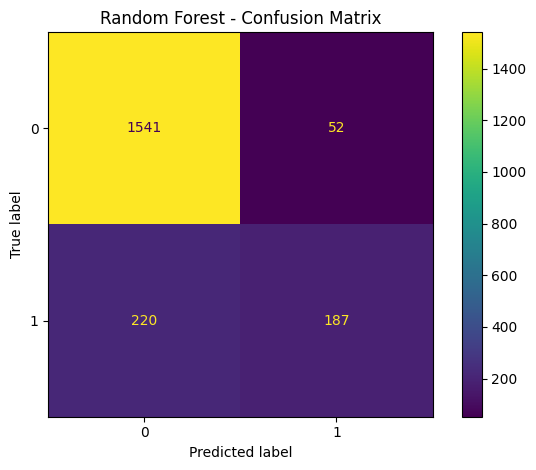

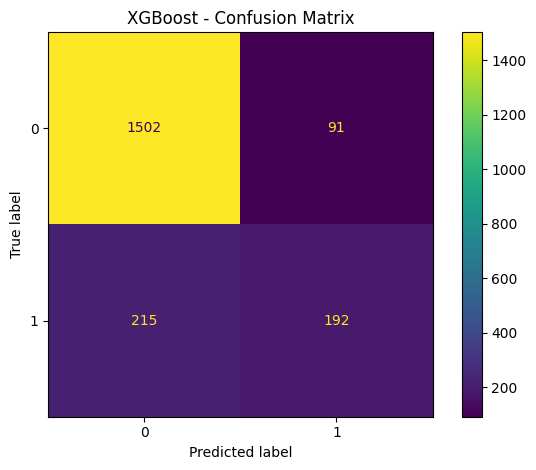

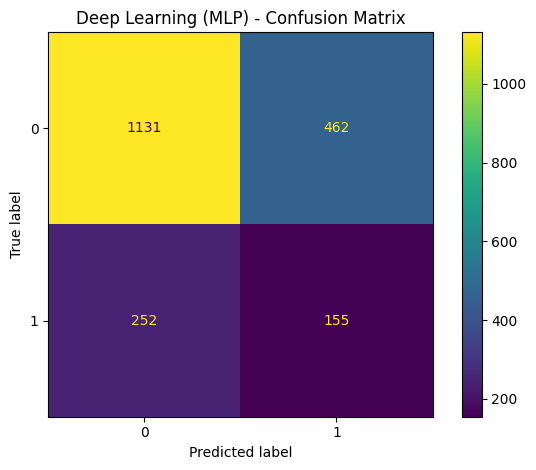

In [11]:
# --- Graphs ---
# Bar plots of metrics
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for metric in metrics_to_plot:
    plt.figure(figsize=(10, 5))
    sns.barplot(
        x=list(detailed_results.keys()),
        y=[detailed_results[model][metric] for model in detailed_results]
    )
    plt.title(f'Model Comparison - {metric}')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

# ROC curves
plt.figure(figsize=(10, 6))
for model_name, metrics in detailed_results.items():
    plt.plot(metrics["FPR"], metrics["TPR"], label=f"{model_name} (AUC = {metrics['AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Confusion Matrices
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    disp.ax_.set_title(f"{model_name} - Confusion Matrix")
    plt.tight_layout()
    plt.show()

